In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
model = torch.load("multi-model-feat64-002.pt")

In [3]:
model.keys()

odict_keys(['main_embed.weight', 'main_embed.bias', 'white_main.weight', 'white_main.bias', 'black_main.weight', 'black_main.bias', 'white_duck.weight', 'white_duck.bias', 'black_duck.weight', 'black_duck.bias'])

In [4]:
integer_scale = 100_000

code = [
    "// Automatically generated by ExtractTables.ipynb\n\n"
    "pub const INTEGER_SCALE: f32 = %.1f;\n" % integer_scale,
]


for weight_name, weight in model.items():
    print("  Weight:", weight_name, weight.shape)
    name = "PARAMS_" + weight_name.replace(".", "_").upper()
    type_name = "f32"
    formatter = "%f"
    if weight_name == "main_embed.weight":
        weight = (integer_scale * weight).to(torch.int32)
        type_name = "i32"
        formatter = "%i"
    if "bias" in weight_name:
        array = " ".join(formatter % x + "," for x in weight)
        code.append("pub const %s: &'static [%s; %i] = &[\n  %s\n];\n" % (
            name,
            type_name,
            weight.shape[0],
            array,
        ))
        continue
    weight = weight.T
    array = "\n".join(
        "  [" + ", ".join(formatter % x for x in row) + "],"
        for row in weight
    )
    code.append("pub const %s: &'static [[%s; %i]; %i] = &[\n%s\n];\n" % (
        name,
        type_name,
        weight.shape[1],
        weight.shape[0],
        array,
    ))

  Weight: main_embed.weight torch.Size([64, 832])
  Weight: main_embed.bias torch.Size([64])
  Weight: white_main.weight torch.Size([65, 64])
  Weight: white_main.bias torch.Size([65])
  Weight: black_main.weight torch.Size([65, 64])
  Weight: black_main.bias torch.Size([65])
  Weight: white_duck.weight torch.Size([65, 64])
  Weight: white_duck.bias torch.Size([65])
  Weight: black_duck.weight torch.Size([65, 64])
  Weight: black_duck.bias torch.Size([65])


In [5]:
with open("src/nnue_data.rs", "w") as f:
    f.write("\n".join(code))

# Debug incorrect outputs

In [67]:
def patch_up_features(feats):
    _, a, b, c = feats.shape
    assert (a, b, c) == (15, 8, 8)
    # feats of shape [batch, 15, 8, 8]
    # is_white_turn of shape [batch]
    is_white_turn = feats[:, -2, 0, 0]
    
    # If we're black then they're in order (black pieces black bottom, white pieces black bottom)
    # We want to convert this into (black pieces white bottom, white pieces white bottom)
    if_black = feats[:, :-2].copy()
    if_black[:, :, :, :] = feats[:, :-2, ::-1, :]

    # If we're white then they're in the order (white pieces white bottom, black pieces, white bottom)
    # We want to just swap the two halves.
    if_white = feats[:, :-2].copy()
    if_white[:, :6, :, :] = feats[:, 6:12, :, :]
    if_white[:, 6:12, :, :] = feats[:, :6, :, :]

    return np.where(
        is_white_turn.reshape(-1, 1, 1, 1),
        if_white,
        if_black,
    ).reshape(-1, 13 * 8 * 8)

feature_count = 13 * 64

class MultiModel(torch.nn.Module):
    FEATS = 64

    def __init__(self):
        super().__init__()
        self.main_embed = torch.nn.Linear(feature_count, self.FEATS)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.white_main = torch.nn.Linear(self.FEATS, 64 + 1)
        self.black_main = torch.nn.Linear(self.FEATS, 64 + 1)
        self.white_duck = torch.nn.Linear(self.FEATS, 64 + 1)
        self.black_duck = torch.nn.Linear(self.FEATS, 64 + 1)

    def forward(self, inputs, which_model):
        embedding = self.main_embed(inputs)
        embedding = self.relu(embedding)
        white_main = self.white_main(embedding)
        black_main = self.black_main(embedding)
        white_duck = self.white_duck(embedding)
        black_duck = self.black_duck(embedding)
        data = torch.stack([white_main, black_main, white_duck, black_duck])
        data = data[which_model, torch.arange(len(which_model))]
        policy = data[:, :64]
        value = data[:, 64:]
        return policy, value, embedding

model = MultiModel()

In [69]:
model.load_state_dict(torch.load("multi-model-feat64-002.pt"))

<All keys matched successfully>

In [70]:
dm_val = np.load("dm_val.npz")

In [71]:
f = patch_up_features(dm_val["features"].reshape(-1, 15, 8, 8))

In [72]:
f.reshape(-1, 13, 8, 8)[0]

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [73]:
starting_feat = f[0].copy().reshape(13, 8, 8)

In [74]:
starting_feat

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [75]:
starting_feat[6, 1, 1] = 1
starting_feat[6, 2, 1] = 0

In [76]:
starting_feat.shape

(13, 8, 8)

In [77]:
a, b, c = model(
    torch.tensor(starting_feat.reshape(1, -1), dtype=torch.float32),
    torch.tensor([0]),
)

In [78]:
b

tensor([[0.0244]], grad_fn=<SliceBackward0>)

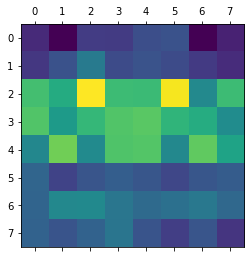

In [79]:
plt.matshow(a.reshape(8, 8).detach().cpu().numpy())

In [80]:
target_linear_state = (c - model.state_dict()["main_embed.bias"]).detach().cpu().numpy()

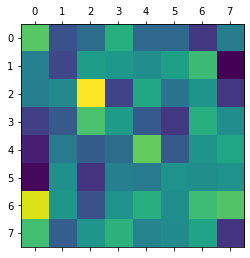

In [81]:
plt.matshow(target_linear_state.reshape(8, 8))

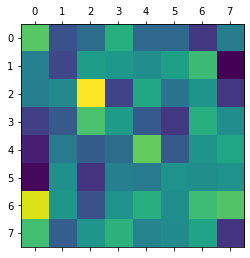

In [82]:
plt.matshow(initial_linear_state.reshape(8, 8))

In [83]:
target_linear_state - initial_linear_state

array([[ 3.08876801e-05,  1.53436279e-05,  3.12026978e-05,
         6.08136368e-05,  2.05711365e-06,  4.33016586e-05,
        -4.92716789e-06,  3.86025238e-05,  3.45972824e-05,
         1.95962524e-05,  4.50337601e-05,  5.85897827e-05,
         4.04574966e-05,  3.68375397e-05,  7.26529694e-05,
         6.12711906e-06,  9.11949158e-06,  2.72644043e-06,
         4.73341370e-05,  5.83420181e-05,  6.04372406e-05,
         1.75389099e-05,  4.84530258e-05,  5.42996120e-05,
         2.09572601e-05,  2.84342575e-05,  4.25994873e-05,
         4.98128510e-05,  2.70796776e-05,  2.83765030e-05,
         3.59075546e-05,  1.83869171e-05,  1.72996521e-06,
         2.49095917e-05,  1.73848534e-05,  4.20160675e-05,
         5.27964783e-05,  1.08203430e-04,  9.98458862e-07,
         4.62950134e-05,  2.55873299e-05,  4.66806030e-05,
         4.36940193e-06,  3.34712219e-05,  2.03408813e-05,
         7.85286713e-05,  5.98062134e-05,  8.96231842e-05,
         4.63949585e-05,  6.61951447e-05,  2.45441818e-0

In [64]:
#initial_linear_state = np.array([120001, 383580, 137398, 283756, 509098, 558127, -12455, 80365, 53778, 28397, -212367, 404435, 60373, 181293, 335118, -277217, 60015, 86152, 57077, -66096, -178402, -244652, 218425, 148898, -4227, -96644, -260137, 223537, 9941, 265566, 22002, 113431, -436525, 49648, -158136, -279139, 16615, 292464, -995, 141168, 28381, 177354, 466708, 105724, 8724, 162147, 426389, -41261, 114401, 169764, -323398, 50508, -32995, 384948, -163998, 207688, 111465, 23619, 168553, 257046, -323129, -294584, 333272, -362578])
initial_linear_state = np.array([208542, 74304, 103035, 177503, 99221, 99967, 49951, 122207, 126187, 64259, 159768, 151716, 140049, 161754, 193359, 5650, 123477, 134962, 280206, 61696, 169496, 112387, 147432, 49673, 58197, 83177, 200995, 156319, 83740, 49658, 178320, 140592, 29850, 120040, 86116, 102971, 214913, 83073, 147879, 166541, 11799, 143009, 47335, 123813, 119054, 147022, 141939, 145978, 265811, 151486, 73656, 147084, 177416, 142320, 194774, 206018, 196784, 89110, 148636, 182453, 128863, 137679, 165823, 47865])
initial_linear_state = initial_linear_state.astype(np.float64)
initial_linear_state /= integer_scale

In [66]:
initial_linear_state

array([2.08542, 0.74304, 1.03035, 1.77503, 0.99221, 0.99967, 0.49951,
       1.22207, 1.26187, 0.64259, 1.59768, 1.51716, 1.40049, 1.61754,
       1.93359, 0.0565 , 1.23477, 1.34962, 2.80206, 0.61696, 1.69496,
       1.12387, 1.47432, 0.49673, 0.58197, 0.83177, 2.00995, 1.56319,
       0.8374 , 0.49658, 1.7832 , 1.40592, 0.2985 , 1.2004 , 0.86116,
       1.02971, 2.14913, 0.83073, 1.47879, 1.66541, 0.11799, 1.43009,
       0.47335, 1.23813, 1.19054, 1.47022, 1.41939, 1.45978, 2.65811,
       1.51486, 0.73656, 1.47084, 1.77416, 1.4232 , 1.94774, 2.06018,
       1.96784, 0.8911 , 1.48636, 1.82453, 1.28863, 1.37679, 1.65823,
       0.47865])